<a href="https://colab.research.google.com/github/matteochieregato/GradientboostingCovid19/blob/main/Feature_extraction_from_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# USA FREEZE MODEL FROM COVID_CT.IPYNB TO EXTRACT CT FEATURES (repeat for all the 10 validation datasets)
!pip install torchio==0.17.53
!pip install shap

In [3]:
# IMPORTO TUTTE LE LIBRERIE

import tempfile
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
import cv2

# librerie pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.optim import Adam
from torch.utils import data
import torch.utils.data as utils
from torch.utils.data import Dataset
from torchvision import transforms

from scipy import stats
import torchvision.models as models
import time
import torch.nn.init as init
import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import SimpleITK as sitk
import copy

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [4]:
torch.cuda.is_available()

True

In [6]:
# retieve model from gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
try:
  os.makedirs('CT_Onco')
  os.chdir('CT_Onco')
  
except Exception as e:
  print(e)



In [ ]:
!tar -xvzf XXX/XXX/Medie.tar.gz

In [9]:
os.chdir('/content')
os.listdir('CT_Onco')

['Medie']

In [10]:
os.listdir('CT_Onco')

['Medie']

In [11]:
images_dir = 'CT_Onco/Medie/'

Import dataset with tabular data

In [12]:
df_completo = pd.read_csv('drive/My Drive/CT_FINE/pz_covid_MATTEO_non_norm_2.csv')
df_completo = df_completo.replace({'ESITO': {'good': 0, 'bad': 1}})

In [13]:
df_LDH = df_completo

In [18]:
# Delete data without CT and LDH
df_LDH_CT = df_completo.dropna(subset=['LDH'])

In [19]:
df_test_finale = df_LDH_CT.sample(frac = 0.2, random_state=109364524) 

In [20]:
df_train = df_LDH.drop(df_test_finale.index)

In [21]:
df_test_finale.head(5)

,id_paziente,ESITO,sesso,eta,bmi,Diabete,Ipertensione,Cardiopatia,Coronaropatia,Oncologico,RDW,HCT,Hb,RBC,GranulocitiBasofiliPerc,GranulocitiEosinofiliPerc,GranulocitiNeutrofiliPerc,WBC,LinfocitiPerc,MonocitiPerc,PLT,VES,Albumina,AST,ALT,BilirubinaTot,CK,Creatinina,LDH,PCR,Urea,Potassio,Sodio,HCO3,Lac,pCO2,pO2FiO2,sO2,FCing,PASing,PADing,TCing,PT_INR
596,3013040062,1,1,51,29.4,0,1,1,0,0,12.9,38.5,13.4,4.49,0.00,0.13,91.5,11.80,5.15,3.21,184,NaN,3.4,60.0,44.0,0.7,460.0,0.96,416,71.8,NaN,3.8,137,27.8,0.7,49,86,91.6,127.0,163.0,102.0,39.6,0.96
493,3002499556,0,1,56,27.7,0,1,1,1,0,12.3,40.4,13.8,4.47,1.43,0.28,79.5,9.11,12.60,6.17,361,54.0,3.0,67.0,81.0,1.3,68.0,0.68,593,153.1,34.0,4.9,139,24.7,1.0,37,224,98.5,127.0,130.0,85.0,37.0,1.07
624,3013042387,0,1,54,29.4,0,1,0,0,0,11.0,34.0,11.7,3.56,0.00,0.85,66.7,5.47,23.90,8.55,227,83.0,3.2,105.0,155.0,0.7,65.0,0.72,259,85.2,26.0,4.2,139,25.6,0.6,36,331,95.1,90.0,116.0,77.0,38.5,0.98
656,3013045956,0,1,60,38.1,0,1,0,0,0,13.4,41.9,13.6,4.57,0.22,2.50,72.6,8.37,13.60,11.00,288,59.0,3.0,46.0,38.0,0.7,122.0,0.78,460,81.9,53.0,3.8,142,31.4,1.7,46,58,70.2,107.0,151.0,84.0,38.5,1.03
66,2000048412,1,0,89,24.4,1,1,1,0,0,13.3,49.4,15.8,4.13,0.00,0.00,77.0,5.86,16.00,7.00,241,31.0,3.5,68.0,13.0,0.4,243.0,3.02,574,139.0,225.0,5.8,153,19.7,3.7,38,38,28.9,108.0,130.0,81.0,37.6,1.12


In [22]:
df_train = pd.concat([df_test_finale, df_LDH]).drop_duplicates(keep = False)

In [23]:
df_validation = df_train.sample(frac = 0.1, random_state=806090) 

In [24]:
df_train = pd.concat([df_train, df_validation]).drop_duplicates(keep = False)

In [25]:
df_test = df_test_finale

In [26]:
data_totale = os.listdir(images_dir)

data_totale_no_doppi = []
dati_no_doppi = []

for i, path in enumerate(os.listdir(images_dir)):
    dati = path.split('_')[0].split('.')[0]
    if dati not in dati_no_doppi:
        dati_no_doppi.append(dati)
        data_totale_no_doppi.append(data_totale[i])

In [27]:
label_train = df_train.loc[df_train['id_paziente'].isin(dati_no_doppi)]
label_validation = df_validation.loc[df_validation['id_paziente'].isin(dati_no_doppi)]
label_test = df_test_finale.loc[df_test_finale['id_paziente'].isin(dati_no_doppi)]

In [28]:
df_train.to_csv('df_train_xxx.csv')

In [29]:
df_validation.to_csv('df_valid_xxx.csv')

In [30]:
gravità_train = []
id_tutti_train = []
for dati in data_totale:
  id_tutti_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [31]:
gravità_validation = []
id_tutti_validation = []
for dati in data_totale:
  id_tutti_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [33]:
df_test_finale.head()

,id_paziente,ESITO,sesso,eta,bmi,Diabete,Ipertensione,Cardiopatia,Coronaropatia,Oncologico,RDW,HCT,Hb,RBC,GranulocitiBasofiliPerc,GranulocitiEosinofiliPerc,GranulocitiNeutrofiliPerc,WBC,LinfocitiPerc,MonocitiPerc,PLT,VES,Albumina,AST,ALT,BilirubinaTot,CK,Creatinina,LDH,PCR,Urea,Potassio,Sodio,HCO3,Lac,pCO2,pO2FiO2,sO2,FCing,PASing,PADing,TCing,PT_INR
596,3013040062,1,1,51,29.4,0,1,1,0,0,12.9,38.5,13.4,4.49,0.00,0.13,91.5,11.80,5.15,3.21,184,NaN,3.4,60.0,44.0,0.7,460.0,0.96,416,71.8,NaN,3.8,137,27.8,0.7,49,86,91.6,127.0,163.0,102.0,39.6,0.96
493,3002499556,0,1,56,27.7,0,1,1,1,0,12.3,40.4,13.8,4.47,1.43,0.28,79.5,9.11,12.60,6.17,361,54.0,3.0,67.0,81.0,1.3,68.0,0.68,593,153.1,34.0,4.9,139,24.7,1.0,37,224,98.5,127.0,130.0,85.0,37.0,1.07
624,3013042387,0,1,54,29.4,0,1,0,0,0,11.0,34.0,11.7,3.56,0.00,0.85,66.7,5.47,23.90,8.55,227,83.0,3.2,105.0,155.0,0.7,65.0,0.72,259,85.2,26.0,4.2,139,25.6,0.6,36,331,95.1,90.0,116.0,77.0,38.5,0.98
656,3013045956,0,1,60,38.1,0,1,0,0,0,13.4,41.9,13.6,4.57,0.22,2.50,72.6,8.37,13.60,11.00,288,59.0,3.0,46.0,38.0,0.7,122.0,0.78,460,81.9,53.0,3.8,142,31.4,1.7,46,58,70.2,107.0,151.0,84.0,38.5,1.03
66,2000048412,1,0,89,24.4,1,1,1,0,0,13.3,49.4,15.8,4.13,0.00,0.00,77.0,5.86,16.00,7.00,241,31.0,3.5,68.0,13.0,0.4,243.0,3.02,574,139.0,225.0,5.8,153,19.7,3.7,38,38,28.9,108.0,130.0,81.0,37.6,1.12


In [34]:
gravità_test = []
id_tutti_test = []
for dati in data_totale:
    id_tutti_test.append(df_test_finale.loc[df_test_finale['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
    gravità_test.append(df_test_finale.loc[df_test_finale['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [ ]:
MRI = 'Lung'
LABEL = 'label'
subjects_train = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        print((image_path.split('.')[0]))
        indexx = id_tutti_train.index(int(image_path.split('.')[0]))
        if (np.isnan(gravità_train[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': gravità_train[indexx],
                'id': image_path.split('.')[0],
                
            }
            
            subject = torchio.Subject(subject_dict)
            subjects_train.append(subject)
    except Exception as e:
        print(e)
dataset_train = torchio.ImagesDataset(subjects_train)
print('Dataset size:', len(dataset_train), 'subjects')

In [ ]:
MRI = 'Lung'
LABEL = 'label'
subjects_valid = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_tutti_validation.index(int(image_path.split('_')[0].split('.')[0]))
        if (np.isnan(gravità_validation[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': gravità_validation[indexx],
                'id': image_path.split('_')[0].split('.')[0],
                
            }
            
            subject = torchio.Subject(subject_dict)
            subjects_valid.append(subject)
    except Exception as e:
        print(e)
dataset_valid = torchio.ImagesDataset(subjects_valid)
print('Dataset size:', len(dataset_valid), 'subjects')

In [ ]:
MRI = 'Lung'
LABEL = 'label'
subjects_test = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_tutti_test.index(int(image_path.split('_')[0].split('.')[0]))
        if (np.isnan(gravità_test[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': gravità_test[indexx],
                'id': image_path.split('_')[0].split('.')[0],
                
            }
            
            subject = torchio.Subject(subject_dict)
            subjects_test.append(subject)
    except Exception as e:
        print(e)
dataset_test = torchio.ImagesDataset(subjects_test)
print('Dataset size:', len(dataset_test), 'subjects')

In [38]:
count = 0
for id in df_test_finale['id_paziente']:
  for data in os.listdir(images_dir):
    if (data.split('_')[0]) == str(id):
      count += 1

In [39]:
count

0

In [40]:
from torchio.transforms import (
    RescaleIntensity,
    ZNormalization,
    Compose,
)
training_transform = Compose([
    RescaleIntensity((0, 1)),    
    ZNormalization(masking_method=ZNormalization.mean),
])

training_subjects = subjects_train
validation_subjects = subjects_valid
test_subjects = subjects_test

training_set = torchio.ImagesDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.ImagesDataset(validation_subjects, transform = training_transform)

test_set = torchio.ImagesDataset(test_subjects, transform = training_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Test set:', len(test_set), 'subjects')

Training set: 411 subjects
Validation set: 42 subjects
Test set: 107 subjects


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).


In [41]:
count_train = [0] * 2
for idx, batch in enumerate(training_subjects):
    if (int(batch['label']) == 1):
        item = 1
    elif (int(batch['label']) == 0):
        item = 0
    count_train[item] += 1

In [42]:
weight_per_class_train = [0.] * 2  
N_train = float(sum(count_train))                                    

In [43]:
for i in range(2):                                                   
    weight_per_class_train[i] = N_train/float(count_train[i]) 
print(int(N_train))
weight_train = [0] * int(N_train)

411


In [44]:
for idx, batch in enumerate(training_subjects):
    if (batch['label'] == 1):
        item = 1
    elif (batch['label'] == 0):
        item = 0
    weight_train[idx] = weight_per_class_train[item]

In [45]:
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weight_train, int(N_train)) 

Definisco i due dataloader per il training e per il validation

In [46]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1, shuffle=True)      
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1)  
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)  

In [47]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.gradients = None

        self.conv1 = nn.Sequential(
        
          nn.Conv3d(1, 20, (3,3,3), bias=False),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv2 = nn.Sequential(
        

          nn.Conv3d(20, 40, (4,4,4), bias=False),
          # pw-linear
          nn.GroupNorm(5, 40),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        
        self.conv3 = nn.Sequential(
        
          nn.Conv3d(40, 80, (3,3,3), bias=False),
          nn.GroupNorm(10, 80),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv4 = nn.Sequential(
        
          nn.Conv3d(80, 160, (3,3,3), bias=False),
          nn.GroupNorm(20, 160),
          nn.ReLU(),
          
          
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        self.conv5 = nn.Sequential(
        
          nn.Conv3d(160, 320,  (4,3,3), bias=False),
          nn.GroupNorm(40, 320),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)

        
        x = self.conv4(x)
        
        
        x = self.conv5(x)

        
        return x


    


In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.encoder = Encoder()
        self.dropout = nn.Dropout(p = 0.25)
        self.convf = nn.Conv3d(320, 640, (2,2,2), bias=False, )
        self.relu = nn.ReLU()  
        self.fc1 = nn.Linear(640 * 4 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40, 2)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(num_features=84)
        self.bn3 = nn.BatchNorm1d(num_features=40)

    def forward(self, x):
        x = self.encoder(x)
        x = self.relu((self.convf(x)))
        x = x.view(-1, 640 * 4 * 2 * 2)
        x = F.tanh(self.bn1((self.fc1(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn2((self.fc2(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn3((self.fc3(x))))
        return x


In [49]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

In [50]:
torch.cuda.is_available()

True

In [51]:
model = torch.load('/content/drive/My Drive/ADNI/model_medie_34_quattordicesima_presa.pth')

In [52]:
from torchsummary import summary

model_pre = Net()
model_pre = model_pre.cuda()

summary(model, (1, 240, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 20, 238, 158, 158]             540
              ReLU-2    [-1, 20, 238, 158, 158]               0
         MaxPool3d-3      [-1, 20, 119, 79, 79]               0
            Conv3d-4      [-1, 40, 116, 76, 76]          51,200
         GroupNorm-5      [-1, 40, 116, 76, 76]              80
              ReLU-6      [-1, 40, 116, 76, 76]               0
         MaxPool3d-7       [-1, 40, 58, 38, 38]               0
            Conv3d-8       [-1, 80, 56, 36, 36]          86,400
         GroupNorm-9       [-1, 80, 56, 36, 36]             160
             ReLU-10       [-1, 80, 56, 36, 36]               0
        MaxPool3d-11       [-1, 80, 28, 18, 18]               0
           Conv3d-12      [-1, 160, 26, 16, 16]         345,600
        GroupNorm-13      [-1, 160, 26, 16, 16]             320
             ReLU-14      [-1, 160, 26,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [57]:
# load weight of pretrained model
model_dict = model_pre.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in model.state_dict().items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model_pre.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [58]:
model_pre

Net(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv3d(1, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv3d(20, 40, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
      (1): GroupNorm(5, 40, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv3d(40, 80, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      (1): GroupNorm(10, 80, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv3d(80, 160, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      (1): GroupNorm(20, 160, eps=1e-05, affine=True)
      (2): ReLU()
  

In [59]:
def estrai_feature(dataloader):
  with torch.no_grad():
    df = pd.DataFrame()
    if dataloader == 0:
        loader = train_loader
    elif dataloader == 1:
        loader = validation_loader
    else:
        loader = test_loader
    outputs = []
    labels = []
    recs = []
    
    for i in range(0, 1):

        print("Training del modello")
        model_pre.eval()  # Set model to training mode

        for batch_idx, batch in enumerate(tqdm(loader)):

            if batch_idx < len(loader):


                inputs = batch['Lung'][DATA].to(dev)
                label = batch['label'].to(dev)
                id_paziente = batch['id']
                print(int(id_paziente[0]))
                print(label.detach().cpu().numpy())

                output = model_pre(inputs)
                output_cpu = np.append(output.detach().cpu().numpy()[0], label.detach().cpu().numpy()[0])
                output_cpu = np.append(id_paziente[0], output_cpu)
                df = df.append([output_cpu])

    df = df.reset_index()
    df = df.drop(columns=['index']) 
    if dataloader == 0:
        split = 'train'
    elif dataloader == 1:
        split = 'validation'
    else:
        split = 'test'
        
    df.to_csv('/content/drive/My Drive/ADNI/feature_estratte_{}.csv'.format(split))
    return df

In [ ]:
# extract features for training dataset
df_train = estrai_feature(0)

In [ ]:
# extract features for validation dataset
df_validation = estrai_feature(1)

In [ ]:
# extract features for test dataset
df_test = estrai_feature(2)

In [62]:
df_train = pd.read_csv('/content/drive/My Drive/ADNI/feature_estratte_train.csv')

In [63]:
df_validation = pd.read_csv('/content/drive/My Drive/ADNI/feature_estratte_validation.csv')

In [64]:
df_test = pd.read_csv('/content/drive/My Drive/ADNI/feature_estratte_test.csv')

In [65]:
df_train.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,3013048256,0.381485,-0.321817,0.713342,-0.016505,0.074139,-0.281794,0.372167,0.735778,-0.266859,-0.323444,0.236006,-0.278052,0.079564,-0.369657,0.305742,-0.152292,0.068270,-0.658991,0.151263,-0.042299,-0.679344,0.124319,0.400390,0.655838,0.522683,-0.342859,0.513634,-0.115870,0.285317,-0.368789,0.302659,0.492751,-0.402648,0.607559,0.446059,0.067317,0.391168,0.299461,-0.845303,-0.559366,0.0
1,1,3007673056,0.489107,0.152016,0.649463,-0.469573,-0.192297,-0.440108,-0.383318,0.919952,-0.321979,-0.779850,-0.638365,-0.198393,-0.278650,-0.501482,0.406906,-0.774091,-0.488798,-0.859393,-0.292457,0.095409,-0.513359,0.055680,0.499309,-0.046021,0.162494,-0.915717,0.642009,-0.773921,0.129741,-0.131316,0.498558,0.578054,0.643248,0.682067,0.785408,-0.436989,0.811221,-0.238115,-0.645566,0.056132,0.0
2,2,3013048570,-0.401382,0.268380,0.889356,-0.575074,0.211980,-0.243104,-0.420811,0.901197,-0.251457,-0.852426,-0.733695,0.273452,-0.214399,-0.763216,0.609081,0.020882,-0.761531,-0.901652,-0.597410,-0.422803,-0.332608,-0.044996,0.855431,-0.432196,0.090630,-0.909705,0.579002,-0.821952,-0.231190,-0.339202,0.580408,0.890039,0.694885,0.753881,0.783264,-0.141979,0.784935,-0.432261,-0.929534,-0.530110,0.0
3,3,3008825560,0.547704,0.317500,0.653333,-0.573078,0.845870,-0.615641,-0.089754,0.076220,0.208629,-0.741348,-0.219622,-0.435629,-0.340831,-0.727775,0.638362,-0.554253,0.503828,-0.805674,-0.194046,-0.337755,0.383296,0.002742,0.695246,-0.126762,-0.376861,-0.464164,0.887999,-0.213041,-0.325831,-0.078575,0.592235,0.833094,-0.272307,0.288345,0.774784,0.297169,0.935147,-0.456492,-0.956146,-0.847588,0.0
4,4,3013062456,0.103039,0.691308,0.548803,-0.791642,0.129505,-0.750935,0.184538,0.616592,-0.146177,-0.195973,-0.084603,0.017934,0.677344,0.049952,0.585913,-0.817310,0.121915,-0.318729,0.097066,-0.130801,-0.291629,-0.553434,-0.629239,-0.481583,-0.544564,-0.116790,0.402155,-0.810366,0.175578,0.701701,0.381481,-0.157680,-0.729371,0.170225,0.525115,0.239252,0.442770,-0.457833,-0.162658,-0.217692,0.0


In [66]:
df_validation.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,2000016520,0.154398,0.380937,0.119034,-0.721049,0.248126,-0.244545,0.034845,0.521951,0.342451,-0.648721,-0.124166,0.283286,-0.426097,-0.498481,0.732019,-0.593878,-0.033322,-0.610252,-0.545843,0.415485,-0.607640,0.200003,-0.247353,-0.319968,0.789710,-0.342210,-0.041920,-0.615580,0.193955,0.608260,-0.474394,-0.020131,0.100459,0.611420,0.060544,0.092378,0.550512,-0.090984,-0.175590,0.732476,0.0
1,1,2006035178,0.473191,0.564125,0.706265,-0.798799,0.903982,-0.781526,0.347173,0.731362,-0.472696,-0.810874,0.050058,-0.161477,-0.501463,-0.791870,0.223876,-0.809458,-0.444555,-0.843670,0.171886,-0.440670,0.153486,0.411037,0.550562,-0.080058,-0.605005,-0.372679,0.129625,-0.842768,-0.646096,-0.531643,0.334676,0.854600,0.424347,0.702415,-0.344372,-0.361541,0.690208,-0.617812,-0.551982,-0.602260,0.0
2,2,3013046856,0.279474,0.468986,-0.512673,0.471725,0.582067,0.191709,-0.109794,-0.221665,-0.756661,0.424834,0.500356,-0.414490,-0.070676,0.523747,-0.506726,-0.002317,0.464904,0.808769,0.186925,-0.626450,-0.042241,-0.492747,-0.860464,0.074756,0.712681,0.683265,-0.553777,0.719539,0.684709,0.480139,0.416839,-0.487519,-0.790941,0.398432,-0.025420,0.603107,-0.519400,0.336311,0.446530,0.745018,0.0
3,3,2011012765,-0.023385,-0.359691,0.476650,-0.755687,0.498072,-0.517663,-0.747783,0.837905,-0.479929,-0.870250,-0.605284,0.371817,-0.358239,-0.532221,0.038013,-0.829895,0.136710,-0.615503,-0.101274,-0.554632,0.132893,0.429331,0.687903,-0.492193,-0.306562,-0.225226,0.916935,-0.482983,0.683113,0.027519,0.328513,0.398362,-0.203941,-0.019619,0.525499,-0.347766,0.725344,-0.301946,-0.719950,-0.379680,0.0
4,4,3002739856,0.007352,0.415356,0.197631,-0.466370,0.454263,-0.063832,-0.385062,0.153345,-0.052233,-0.508862,-0.380898,0.403949,-0.396676,-0.843773,0.587338,-0.872974,-0.180807,-0.737200,-0.191791,-0.794580,0.230110,0.043856,-0.522582,-0.247160,0.580368,-0.387570,0.923870,-0.479408,0.098287,-0.158411,0.419096,0.589699,-0.004367,0.747297,0.626933,-0.198042,0.823397,-0.412149,-0.623604,-0.148935,1.0


In [67]:
df_train = df_train.drop(columns='Unnamed: 0')

In [68]:
df_validation = df_validation.drop(columns='Unnamed: 0')

In [69]:
df_test = df_test.drop(columns='Unnamed: 0')

In [70]:
df_train = df_train.replace({'Rec': {'Torace':'TORACE', 'BONEa': 'BONE', 'OSSO':'BONE', 'PARENCHIMAb':'PARENCHIMA', 'osso':'BONE',
                        'PARENCHIMAa': 'PARENCHIMA', 'TORACEa': 'TORACE', 'torace': 'TORACE', 'Embolia': 'EMBOLIA',
                        'bone': 'BONE', '50ML':'ULTRAVIST', '60ml': 'ULTRAVIST', '60ML':'ULTRAVIST', '70ml': 'ULTRAVIST',
                        '70': 'ULTRAVIST', '80ML': 'ULTRAVIST', '70ML': 'ULTRAVIST', '100ml': 'ULTRAVIST', '7OML': 'ULTRAVIST',
                        'ULTRA': 'ULTRAVIST', 'std': 'STD', 'ax':'AX', '50ml': 'ULTRAVIST', 'mop':'LUNG', 'STND': 'STD',
                        'TC': 'TORACE', 'AX': 'BONE', 'RETRO':'BONE', '00': '06', '0': '06', '1': 'LUNG', '2': 'LUNG',
                        'BASALE': 'TORACE', 'TORACE':'STD', 'SENZA': 'STD'}})

In [71]:
def retrieve_rec(df, rec):
    df = df.loc[df.Rec == rec.upper()]
    return df

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
import seaborn as sns

In [74]:
# plot first extracted feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

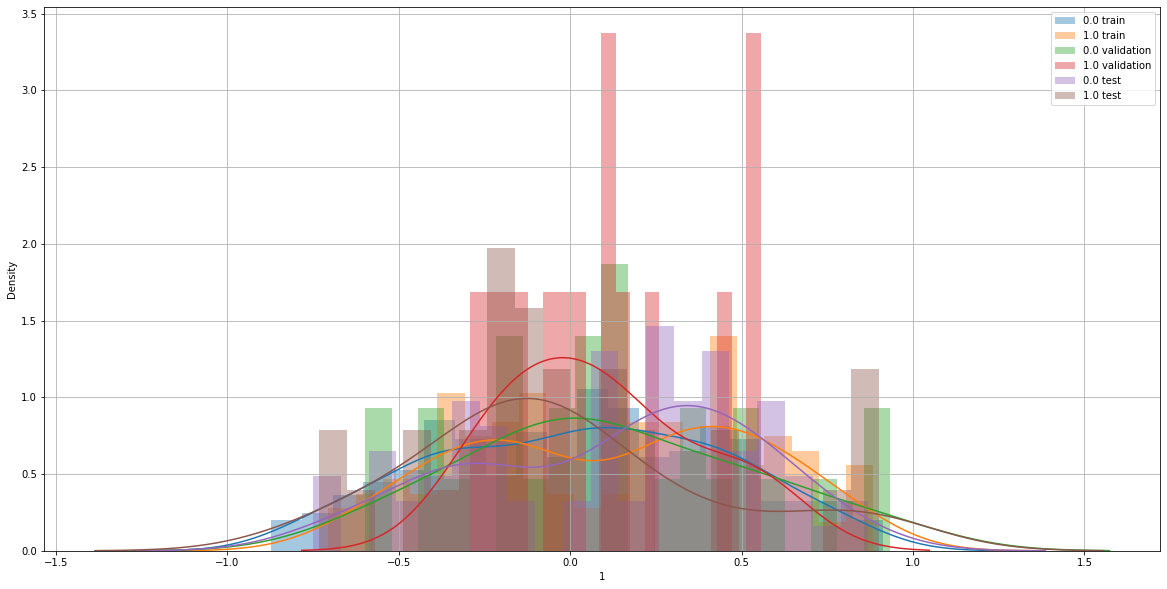

In [75]:
plt.figure(figsize=(20,10))
plt.grid()
for i,j in df_train.groupby(['41']):
    sns.distplot(j['1'], bins=20, label=str(i)+ ' train')
for i,j in df_validation.groupby(['41']):
    sns.distplot(j['1'], bins=20, label=str(i)+ ' validation')    
for i,j in df_test.groupby(['41']):
    sns.distplot(j['1'], bins=20, label=str(i)+ ' test') 
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

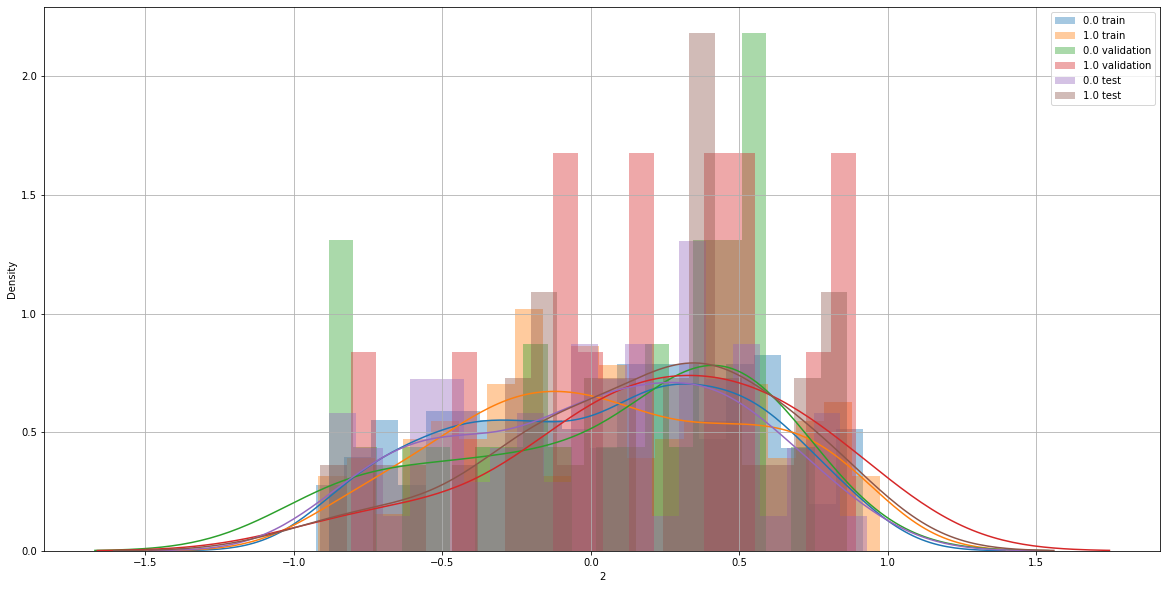

In [76]:
plt.figure(figsize=(20,10))
plt.grid()
for i,j in df_train.groupby(['41']):
    sns.distplot(j['2'], bins=20, label=str(i)+ ' train')
for i,j in df_validation.groupby(['41']):
    sns.distplot(j['2'], bins=20, label=str(i)+ ' validation')     
for i,j in df_test.groupby(['41']):
    sns.distplot(j['2'], bins=20, label=str(i)+ ' test')     
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

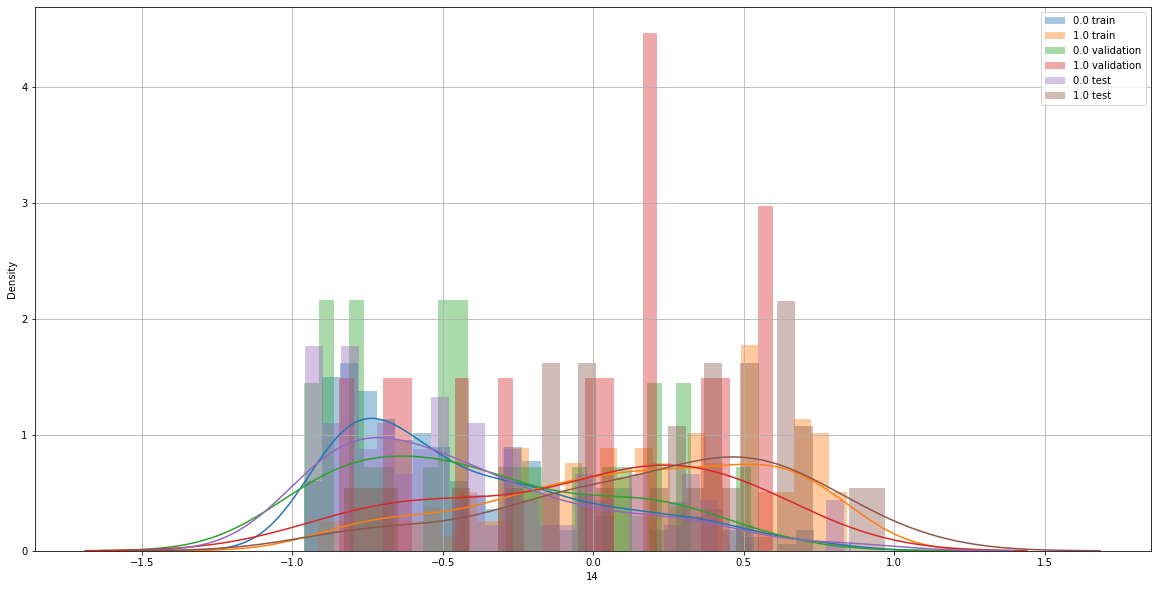

In [77]:
plt.figure(figsize=(20,10))
plt.grid()
for i,j in df_train.groupby(['41']):
    sns.distplot(j['14'], bins=30, label=str(i)+ ' train')
for i,j in df_validation.groupby(['41']):
    sns.distplot(j['14'], bins=30, label=str(i)+ ' validation')  
for i,j in df_test.groupby(['41']):
    sns.distplot(j['14'], bins=30, label=str(i)+ ' test')  
plt.legend()

In [78]:
# Use PCA for dimensionality reduction
from sklearn.decomposition import PCA

In [79]:
pca = PCA(n_components=5)

In [80]:
df_pca_train = df_train.drop(columns=['41'])

In [81]:
df_pca_train = df_pca_train.drop(columns=['0'])

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_2_train = scaler.fit_transform(df_pca_train)

In [83]:
projected_train = pca.fit_transform(df_2_train)

In [84]:
projected_df_train = pd.DataFrame(projected_train, columns=["x_1", "x_2", "x_3", "x_4", "x_5"])

In [85]:
projected_df_train.head()

,x_1,x_2,x_3,x_4,x_5
0,-0.352287,0.021740,0.076840,-0.421505,-0.264456
1,-1.123089,-0.215859,0.028103,0.064751,-0.109103
2,-1.519729,-0.125908,0.043151,0.056560,0.383059
3,-1.042389,0.330535,0.335413,-0.635527,-0.196290
4,-0.103531,0.566742,0.416965,-0.091835,0.066042


In [86]:
projected_df_train.insert(5, "Esito", df_train['41'].values, True) 

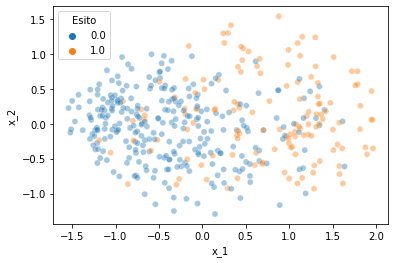

In [87]:
sns.scatterplot( x="x_1", y="x_2",
  data=projected_df_train,  
  hue='Esito',
  legend='full',
  alpha=0.4)

In [88]:
df_pca_validation = df_validation.drop(columns=['41'])
df_pca_test = df_test.drop(columns=['41'])

In [89]:
df_pca_validation = df_pca_validation.drop(columns=['0'])
df_pca_test = df_pca_test.drop(columns=['0'])

In [90]:
df_2_validation = scaler.transform(df_pca_validation)
projected_validation = pca.transform(df_2_validation)

df_2_test = scaler.transform(df_pca_test)
projected_test = pca.transform(df_2_test)

In [91]:
projected_df_validation = pd.DataFrame(projected_validation, columns=["x_1", "x_2", "x_3", "x_4", "x_5"])
projected_df_test = pd.DataFrame(projected_test, columns=["x_1", "x_2", "x_3", "x_4", "x_5"])

In [92]:
projected_df_validation.insert(5, "Esito", df_validation['41'].values, True) 
projected_df_test.insert(5, "Esito", df_test['41'].values, True) 

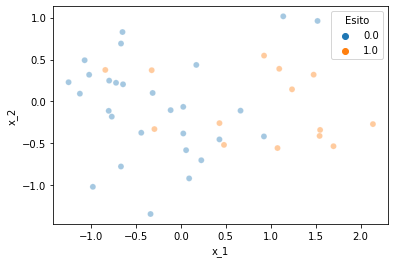

In [93]:
sns.scatterplot( x="x_1", y="x_2",
  data=projected_df_validation,  
  hue='Esito',
  legend='full',
  alpha=0.4)

In [94]:
projected_df_test.head()

,x_1,x_2,x_3,x_4,x_5,Esito
0,0.905638,0.108435,0.276765,0.026647,0.377432,1.0
1,0.669177,0.179852,-1.013334,0.581169,-0.251145,0.0
2,0.553495,-0.279194,0.470302,-0.408934,0.705828,1.0
3,-0.129090,0.352573,0.137532,0.490040,-0.073411,1.0
4,-0.345050,0.645391,-0.350537,0.051127,-0.085951,0.0


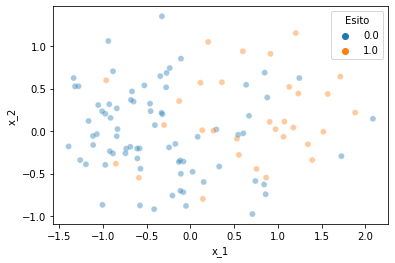

In [95]:
sns.scatterplot( x="x_1", y="x_2",
  data=projected_df_test,  
  hue='Esito',
  legend='full',
  alpha=0.4)

In [96]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})

0.0
1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

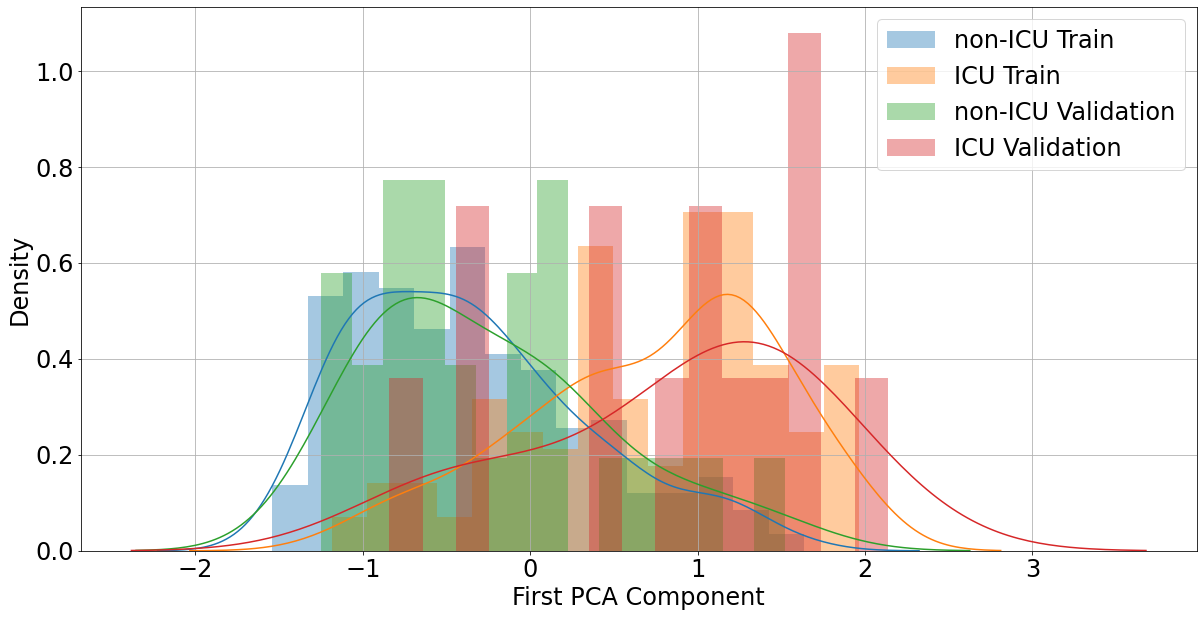

In [97]:
plt.figure(figsize=(20,10))
plt.grid()
for i,j in projected_df_train.groupby(['Esito']):
    print(i)
    if i == 0:
      labels = 'non-ICU'
    else:
      labels = 'ICU'
    sns.distplot(j['x_1'], bins=15, label=labels + ' Train')

for i,j in projected_df_validation.groupby(['Esito']):
      if i == 0:
        labels = 'non-ICU'
      else:
        labels = 'ICU'
      sns.distplot(j['x_1'], bins=15, label=labels + ' Validation')
plt.xlabel("First PCA Component")
plt.legend()
plt.savefig('First_PCA.pdf')

In [98]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

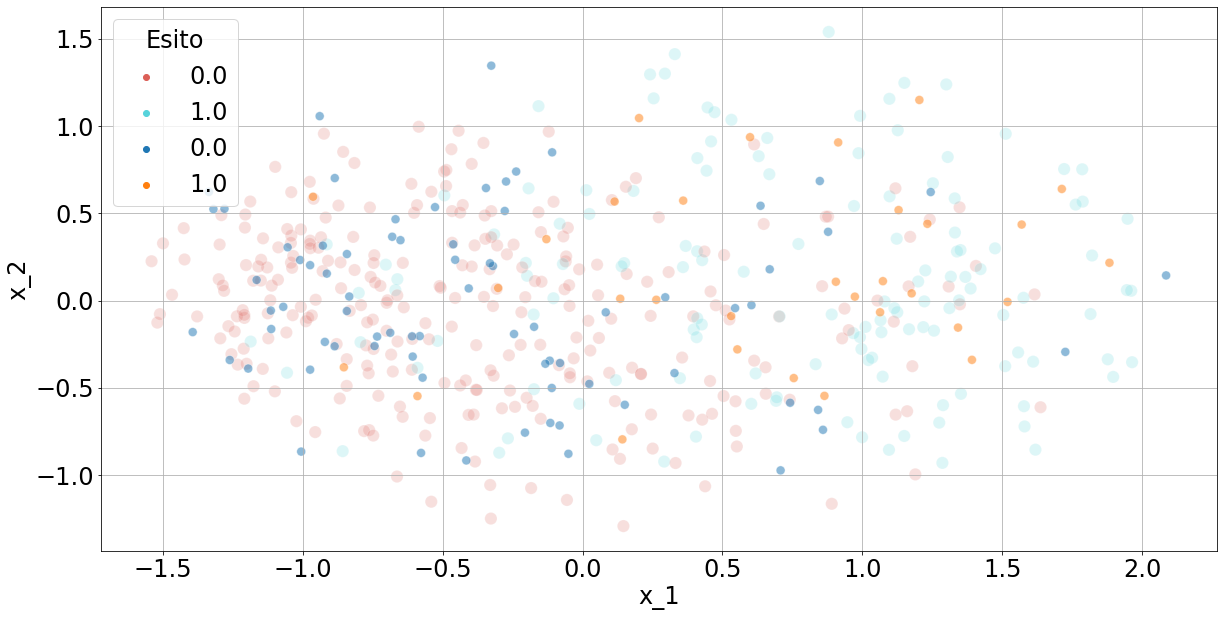

In [99]:
plt.figure(figsize=(20,10))
plt.grid()
sns.scatterplot( x="x_1", y="x_2",
  data=projected_df_train,  
  hue='Esito',
  legend='full',
  alpha=0.2,
  palette='hls',
  s=150)
sns.scatterplot( x="x_1", y="x_2",
  data=projected_df_test,  
  hue='Esito',
  legend='full',
  alpha=0.5,
  s = 80)

In [100]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = projected_df_train[["x_1", "x_2"]], projected_df_validation[["x_1", "x_2"]], projected_df_train['Esito'], projected_df_validation['Esito']

In [101]:
X_train_pca.head()

,x_1,x_2
0,-0.352287,0.021740
1,-1.123089,-0.215859
2,-1.519729,-0.125908
3,-1.042389,0.330535
4,-0.103531,0.566742
